# HW1 Solutions: Introduction to RL 


This notebook is designed for is designed to provide hands-on experience with RL modeling, algorithm implementation, and performance evaluation. Students will explore RL concepts through predefined environments and custom-designed settings.

Follow the instructions in each section to complete the homework.

## Setup Instructions
Seting up RL dependecies for first time may be challenging. Some  torch or gymnasium (Sklearn lib in SL world!) environments need additional set up on your system. If you encountered error and failure after hours of search and try feel free to be in contact with TA's.  Run the following commands to install dependencies before starting the notebook:



In [1]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install xvfb

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [ ]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install swig
!pip install stable-baselines3 "gymnasium[all]" pygame matplotlib numpy pandas

But for saving game as **video** he defined a function (it's okay if you don't understand just try to run the code and see the output, then try to modify envs!):

In [8]:
import logging
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

training_period = 250  # record the agent's episode every 250
num_training_episodes = 1000  # total number of training episodes

env = gym.make("MountainCar-v0", render_mode="rgb_array")
env = RecordVideo(env, video_folder="MountainCar-v0-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env)

for episode_num in range(num_training_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated

    logging.info(f"episode-{episode_num}", info["episode"])
env.close()

The videos are in MountainCar-v0-agent folder of your colab folder.

**Loading saved model**

After training model using PPO and saving it, Hamid started to load the model with the name he saved in cell above:

In [ ]:
model = PPO.load("ppo_MountainCar")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    print(obs, rewards, dones, info)
    if dones[0]:
      break

# **Task 1: Solving Predefined Environments (45 points)**
1.1. Choose two environments from the list which are implemented by  other developers and communities and train RL agents using stable-baselines3. Don't forget to check workshop notebook.

**Environments:**
- [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
- [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)
- [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/)
- Flappy Bird (Custom env which you can google it)

📊 1.2. Algorithm Comparison:


 Compare RL algorithms and results (at least two algorithms e.g., PPO, DQN) based on:
- Total reward over time
- Hyperparameters (check the docs)


In [3]:
%load_ext tensorboard

## 1.1 CartPole Solution: 




In [8]:
# Import CartPole env 
from stable_baselines3 import A2C , PPO , DQN
import gymnasium as gym
from gymnasium import spaces
import numpy as np

env = gym.make("CartPole-v1")
# Train env With A2C
model = A2C("MlpPolicy", env, verbose=1, tensorboard_log="./a2c_CartPole_tensorboard/")
model.learn(total_timesteps=500_000)
model.save("a2c_cartpole")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./a2c_CartPole_tensorboard/A2C_3
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 41.4     |
|    ep_rew_mean        | 41.4     |
| time/                 |          |
|    fps                | 657      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.583   |
|    explained_variance | 0.248    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.32     |
|    value_loss         | 4.74     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 37.3     |
|    ep_rew_mean        | 37.3     |
| time/                 |          |
|    fps                | 708      |
|    iterat

KeyboardInterrupt: 

In [ ]:
# Train env With PPO
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./PPO_CartPole_tensorboard/")
model.learn(total_timesteps=500_000)
model.save("ppo_cartpole")

In [7]:
# plot env1 total rewards on sepearate lines for each algorithm
!tensorboard --logdir ./a2c_CartPole_tensorboard

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


## Modify hyperparameters for cartpole

In [14]:
# modify hyperparameters and plot reward curves
learning_rates = [0.0001, 0.01]  
gammas = [0.95, 0.99]

for lr in learning_rates:
    for gamma in gammas:
        model = PPO("MlpPolicy",
                    env, verbose=0,
                    learning_rate=lr, 
                    gamma=gamma ,
                    tensorboard_log=f'./PPO_CartPole_tensorboard/ppo_lr{lr}_gamma{gamma}')
        model.learn(total_timesteps=200_000)

## wrapper for reward function of Cartpole

In [ ]:
from gymnasium import  RewardWrapper
class DoubledReward(RewardWrapper):
    def reward(self, reward):
        return reward * 2

wrapped_env = DoubledReward(env)

model = PPO("MlpPolicy", wrapped_env, verbose=0, tensorboard_log="./PPO_CartPole_tensorboard/reward_wrapped_env_ppo")
model.learn(total_timesteps=500_000)

## 1.2 FrozenLake implementation.

In [2]:
from stable_baselines3 import A2C , PPO , DQN
import gymnasium as gym
from gymnasium import spaces
import numpy as np


env = gym.make("FrozenLake-v1" , is_slippery=True)
# Train env With DQN
model = DQN("MlpPolicy" ,env , verbose=0, tensorboard_log="./DQN_FrozenLake_tensorboard/")
model.learn(total_timesteps=500_000)
model.save("DQN_FrozenLake")

In [3]:
# Train env With A2C
model = A2C("MlpPolicy" ,env , verbose=0, tensorboard_log="./A2C_FrozenLake_tensorboard/")
model.learn(total_timesteps=500_000)
model.save("A2C_FrozenLake")

## Modify DQN hyperparameters for FrozenLake

In [4]:
# modify hyperparameters and plot reward curves
learning_rates = [0.0001, 0.01]  
gammas = [0.95, 0.99]

for lr in learning_rates:
    for gamma in gammas:
        model = DQN("MlpPolicy",
                    env, verbose=0,
                    learning_rate=lr, 
                    gamma=gamma ,
                    tensorboard_log=f'./DQN_FrozenLake_tensorboard/DQN_lr{lr}_gamma{gamma}')
        model.learn(total_timesteps=300_000)

## wrapper for reward function of FrozenLake

In [5]:
from gymnasium import  RewardWrapper
class ModifiedFrozenLakeReward(RewardWrapper):
    def reward(self, reward):
        if reward == 0:            
            return -0.01
        elif reward == 1:           
            return 2
        else:
            return reward

wrapped_env = ModifiedFrozenLakeReward(env)

model = DQN("MlpPolicy", wrapped_env, verbose=0, tensorboard_log="./DQN_FrozenLake_tensorboard/reward_wrapped_env_DQN")
model.learn(total_timesteps=500_000)

## 1.3 Taxi Env implementation.

In [11]:
from stable_baselines3 import A2C , PPO , DQN
import gymnasium as gym
from gymnasium import spaces
import numpy as np

env = gym.make("Taxi-v3")
# Train env With DQN
model = DQN("MlpPolicy" ,env , verbose=0, tensorboard_log="./DQN_Taxi_tensorboard/")
model.learn(total_timesteps=500_000)
model.save("DQN_Taxi")

In [13]:
# Train env With PPO
model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./PPO_Taxi_tensorboard/")
model.learn(total_timesteps=500_000)
model.save("ppo_Taxi")

seems we should solve taxi using better algorithms. we use q learning

## Q-Learning for Taxi 

In [5]:
import numpy as np
import random
import gymnasium as gym
from torch.utils.tensorboard import SummaryWriter



def qlearning_train(taxi_env , learning_rate , discount_factor ):
    
    # we use the tensorboard writer
    writer = SummaryWriter(f"Qlearning_Taxi/taxi_experiment_lr_{learning_rate}_{discount_factor}")
    
    # q table dimensions based on state and action space
    num_states = taxi_env.observation_space.n
    num_actions = taxi_env.action_space.n
    q_values = np.zeros((num_states, num_actions))
    
    # hyperparameters for the problem
    alpha = learning_rate          # learning rate
    gamma = discount_factor         # discount factor
    eps = 1.0            # initial exploration probability
    decay = 0.005        # epsilon decay rate per episode
    episodes = 5000
    max_steps_per_ep = 99
    
    
    episode_rewards = []
    print("training...")
    
    for ep in range(episodes):
        # reseting the environment
        state, _ = taxi_env.reset()
        total_reward = 0
    
        for step in range(max_steps_per_ep):
            
            if random.random() < eps:
                chosen_action = taxi_env.action_space.sample()
            else:
                chosen_action = np.argmax(q_values[state, :])
            
            next_state, reward, done, _, _ = taxi_env.step(chosen_action)
            
            q_values[state, chosen_action] += alpha * (
                reward + gamma * np.max(q_values[next_state, :]) - q_values[state, chosen_action]
            )
    
            state = next_state
            total_reward += reward
    
            if done:
                break
    
        # decay epsilon over episodes
        eps = 1  / (1  + decay * ep)
        episode_rewards.append(total_reward)
        
        avg_reward = np.mean(episode_rewards[-100:]) if ep >= 100 else np.mean(episode_rewards)
        writer.add_scalar("Mean_Episode_Reward", avg_reward, ep)
    
    print(f"Training completed over {episodes} episodes.")
    writer.close()
    taxi_env.close()
    return q_values

we test with different hyperparameters

In [6]:
# create Taxi environment
taxi_env = gym.make("Taxi-v3", render_mode="ansi")

learning_rates = [0.1, 0.9]  
gammas = [0.95, 0.99]

for lr in learning_rates:
    for gamma in gammas:
        q_values = qlearning_train(taxi_env = taxi_env , learning_rate = lr , discount_factor = gamma )

training...
Training completed over 5000 episodes.
training...
Training completed over 5000 episodes.
training...
Training completed over 5000 episodes.
training...
Training completed over 5000 episodes.


we can render the result here:

In [26]:
from time import sleep

def simulate_agent(environment, q_matrix, num_runs=5, max_steps_per_run= 100):
    for run in range(num_runs):
        current_state, _ = environment.reset()
        finished = False
        print(f"Run {run + 1}\n")
        sleep(1)

        for step in range(max_steps_per_run):            
            print(environment.render())
            sleep(0.5)  
            
            chosen_action = np.argmax(q_matrix[current_state, :])
            next_state, reward, finished, _, _ = environment.step(chosen_action)
            current_state = next_state

            if finished:
                print(f"Run completed in {step + 1} steps.\n")
                sleep(2)
                break

taxi_env = gym.make("Taxi-v3", render_mode="ansi")
simulate_agent(taxi_env, q_values, num_runs=2)

Run 1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: |_: :G|
| : | : : |
| : : : : |
| | :

## Wrapping Taxi reward

In [36]:
from gymnasium import  RewardWrapper
class CustomTaxiReward(RewardWrapper):
    def reward(self, reward):
        if reward == -10:            
            return -40     
        else:
            return reward
            
taxi_env.reset()
wrapped_taxi_env = CustomTaxiReward(taxi_env)

qlearning_train(taxi_env = wrapped_taxi_env , learning_rate = 0.9 , discount_factor = .99 )

training...
Training completed over 5000 episodes.


## 1.4 Implementing Flappy Bird

In this section we used the third party repo for flappy bird game from this [link](https://github.com/markub3327/flappy-bird-gymnasium).

First we install it:


In [ ]:
!pip install flappy-bird-gymnasium

Then we check render in Human mode

In [4]:
import flappy_bird_gymnasium
import gymnasium
env = gymnasium.make("FlappyBird-v0", render_mode="human", use_lidar=True)

obs, _ = env.reset()
while True:    
    action = env.action_space.sample()

    # Processing:
    obs, reward, terminated, _, info = env.step(action)
    
    # Checking if the player is still alive
    if terminated:
        break

env.close()

Now we check the action and observation space

In [49]:
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)
# Display action space
print(f"Action Space Type: {type(env.action_space)}")
print(f"Action Space: {env.action_space}")

# Display observation space
print(f"\nObservation Space Type: {type(env.observation_space)}")
print(f"Observation Space: {env.observation_space}")

# Take a random action
action = env.action_space.sample()
env.reset()
next_state, reward, done, truncated, info = env.step(action)

# Display step results
print("\nExample Step Results:")
print(f"Action Taken: {action}")
print(f"New State: {next_state}")
print(f"Reward Received: {reward}")

Action Space Type: <class 'gymnasium.spaces.discrete.Discrete'>
Action Space: Discrete(2)

Observation Space Type: <class 'gymnasium.spaces.box.Box'>
Observation Space: Box(0.0, 1.0, (180,), float64)

Example Step Results:
Action Taken: 1
New State: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.      

In [50]:
# Train env With A2C
model = A2C("MlpPolicy" ,env , verbose=0, tensorboard_log="./A2C_FlappyBird_tensorboard/")
model.learn(total_timesteps=5_000_000)
model.save("A2C_FlappyBird")

In [51]:
# Train env With PPO
model = PPO("MlpPolicy" ,env , verbose=0, tensorboard_log="./PPO_mlp_FlappyBird_tensorboard/")
model.learn(total_timesteps=5_000_000)
model.save("PPO_FlappyBird")

## Wrapping FlappyBird reward

In [ ]:
from gymnasium import  RewardWrapper
class ModifiedFlappyBirdReward(RewardWrapper):
    def reward(self, reward):
        if reward == - 0.5:  #- touch the top of the screen          
            return -2 # we penalty touching the screen more
        elif reward == 1:           
            return 2
        else:
            return reward

wrapped_env = ModifiedFlappyBirdReward(env)

model = DQN("MlpPolicy", wrapped_env, verbose=0, tensorboard_log="./DQN_FrozenLake_tensorboard/reward_wrapped_env_DQN")
model.learn(total_timesteps=500_000)

# Task 2 Solution: Creating Custom Environment (45 points)
In this question, you were required to model **a custom 4*4 gridworld problem** as Markov Decision Processes (MDPs). 

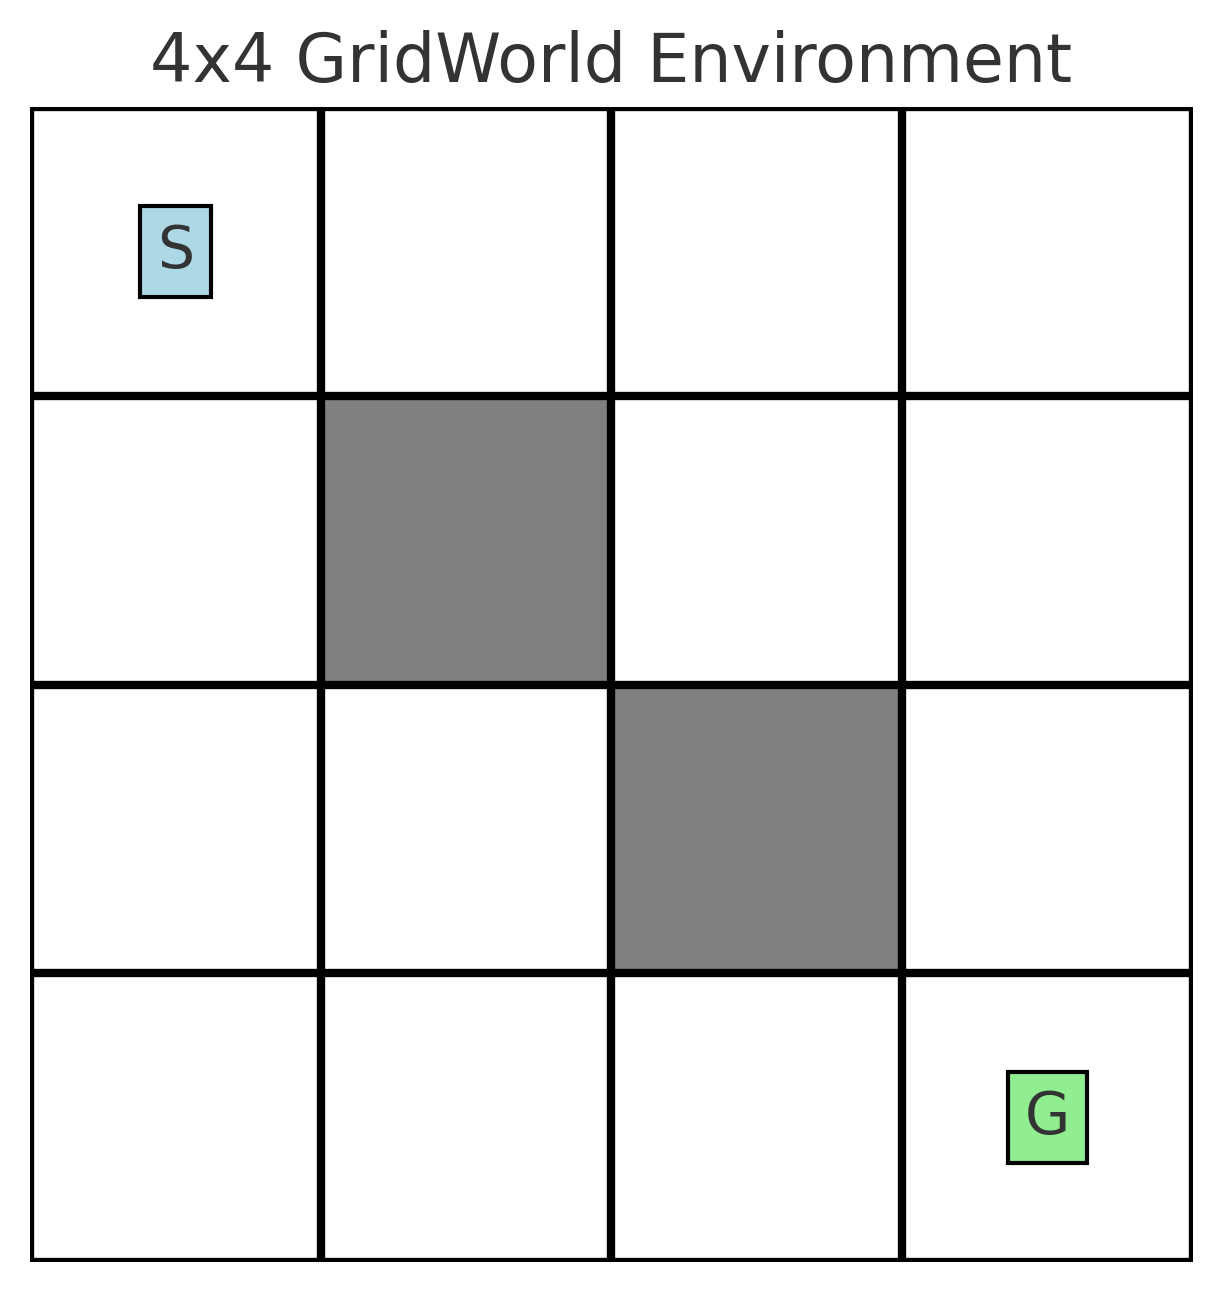



- **State Space ($ S $)**: The state space is all 4*4 = 16 cells in the grid. So the states are tuples like (row, column):

  -  Starts at (0,0) for the top-left “S.”
  - Ends at (3,3) for the bottom-right “G.”
  -  Holes are at (1,1) and (2,2).
  -  the other 10 cells are just regular places

   So, S = {(0,0), (0,1), ..., (3,2), (3,3)}. That’s 16 possible states where the agent can be at any time.

- **Action Space ($ A $)**: 
The agent can move in four directions: up, down, left, or right. We’ll keep it simple and define:

    A = {0: up, 1: down, 2: left, 3: right}. Four actions. In code, we’ll use numbers 0 to 3 to keep it easy for gymnasium.


- **Reward Function ($ R $)**:

  - Reaching the goal (G) at (3,3): +10 reward.
  - Falling into a hole at (1,1) or (2,2): -1 reward. 
  - Moving anywhere else (white cells or hitting a wall): 0 reward.
  


- **Transition Probability ($ P $)**: We assume this is deterministic environment.


In [209]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridWorldEnv(gym.Env):
    def __init__(self):       
        self.grid_size = 4
        self.start = (0, 0)  
        self.goal = (3, 3)  
        self.holes = [(1, 1), (2, 2)]  
        self.state = self.start
        
        
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Discrete(16)  # from 0 to 15 for the problem states

    def get_observation(self):
        """we convert internal state (i, j) to integer observation using state = 4*i + j."""
        i, j = self.state
        return 4 * i + j

    def step(self, action):        
        row, col = self.state
        
         
        if action == 0:  # up
            next_row = max(row - 1, 0)
            next_col = col
        elif action == 1:  # down
            next_row = min(row + 1, 3)
            next_col = col
        elif action == 2:  # left
            next_row = row
            next_col = max(col - 1, 0)
        elif action == 3:  # right
            next_row = row
            next_col = min(col + 1, 3)

        next_state = (next_row, next_col)
        
        # rewards
        if next_state in self.holes:
            reward = -1
            done = True
        elif next_state == self.goal:
            reward = 10
            done = True
        else:
            reward = 0
            done = False
        
        # Update the internal state
        self.state = next_state
        # Return observation as integer, along with reward and status
        return self.get_observation(), reward, done, False, {}

    def render(self):
        """Render the grid world with the agent's position."""
        # Initialize a 4x4 grid with empty cells
        grid = [['.' for _ in range(4)] for _ in range(4)]
        
        grid[0][0] = 'S'               # Start
        grid[3][3] = 'G'               # Goal
        for hole in self.holes:        # Holes
            grid[hole[0]][hole[1]] = 'H'
        
        agent_row, agent_col = self.state
        if grid[agent_row][agent_col] == 'S':
            grid[agent_row][agent_col] = 'A'  # Agent on start
        elif grid[agent_row][agent_col] == 'G':
            grid[agent_row][agent_col] = 'A'  # Agent on goal
        elif grid[agent_row][agent_col] == 'H':
            grid[agent_row][agent_col] = 'A(H)'  # Agent on hole
        else:
            grid[agent_row][agent_col] = 'A'     # Agent on empty cell
        
        # Print the grid
        for row in grid:
            print('    '.join(row))
        print()  # empty line 

    def reset(self):
        """Reset the environment to the start state and return initial observation."""
        self.state = self.start
        return self.get_observation(), {}

# quick test
env = GridWorldEnv()
env.render()
print("Starting state:", env.reset())
action = 3  # move right action for test
next_state, reward, done, truncated , _ = env.step(action)
print("After moving right:", next_state, "Reward:", reward, "Done:", done)

A    .    .    .
.    H    .    .
.    .    H    .
.    .    .    G

Starting state: (0, {})
After moving right: 1 Reward: 0 Done: False


In [210]:
def qlearning_train_gridworld(env , learning_rate , discount_factor ):
    
    # we use the tensorboard writer
    writer = SummaryWriter(f"Qlearning_GridWorld/experiment_lr_{learning_rate}_{discount_factor}")
    
    # q table dimensions based on state and action space
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    q_values = np.zeros((num_states, num_actions))
    
    # hyperparameters for the problem
    alpha = learning_rate          # learning rate
    gamma = discount_factor         # discount factor
    eps = 1.0            # initial exploration probability
    decay = 0.005        # epsilon decay rate per episode
    episodes = 5000
    max_steps_per_ep = 99
    
    
    episode_rewards = []
    print("training...")
    
    for ep in range(episodes):
        # reseting the environment
        state, _ = env.reset()
        total_reward = 0
    
        for step in range(max_steps_per_ep):
            
            if random.random() < eps:
                chosen_action = env.action_space.sample()
            else:
                chosen_action = np.argmax(q_values[state, :])
            
            next_state, reward, done, _, _ = env.step(chosen_action)
            
            q_values[state, chosen_action] += alpha * (
                reward + gamma * np.max(q_values[next_state, :]) - q_values[state, chosen_action]
            )
    
            state = next_state
            total_reward += reward
    
            if done:
                break
    
        # decay epsilon over episodes
        eps = 1  / (1  + decay * ep)
        episode_rewards.append(total_reward)
        
        avg_reward = np.mean(episode_rewards[-100:]) if ep >= 100 else np.mean(episode_rewards)
        writer.add_scalar("Mean_Episode_Reward", avg_reward, ep)
    
    print(f"Training completed over {episodes} episodes.")
    writer.close()
    env.close()

    return q_values

In [216]:
def simulate_gridworld_agent(environment, q_matrix,  max_steps_per_run= 100):
    print("environment" , environment)
    
    current_state, _ = environment.reset()
    print(current_state)
    finished = False    
    sleep(1)

    for step in range(max_steps_per_run):            
        environment.render()
        sleep(0.5)  
        
        chosen_action = np.argmax(q_matrix[current_state, :])
        next_state, reward, finished, _, _ = environment.step(chosen_action)
        current_state = next_state

        if finished:
            environment.render()
            print(f"Run completed in {step + 1} steps.\n")
            sleep(2)
            break

In [212]:
env = GridWorldEnv()
q_values = qlearning_train_gridworld(env = env , learning_rate = 0.9 , discount_factor = .99 )

training...
Training completed over 5000 episodes.


In [214]:
q_values

array([[ 9.41480149,  9.32065348,  9.41480149,  9.5099005 ],
       [ 9.5099005 , -1.        ,  9.41480149,  9.6059601 ],
       [ 9.6059601 ,  9.70299   ,  9.5099005 ,  9.70299   ],
       [ 9.70299   ,  9.801     ,  9.6059601 ,  9.70299   ],
       [ 9.41480149,  9.22737868,  9.32065347, -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 9.6059601 , -1.        , -1.        ,  9.801     ],
       [ 9.70299   ,  9.9       ,  9.70299   ,  9.801     ],
       [ 9.32065234,  0.        ,  7.45897358,  0.        ],
       [-0.99      ,  0.        ,  0.        , -0.999     ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 9.801     , 10.        , -1.        ,  9.9       ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.999     ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [217]:
simulate_gridworld_agent(environment = env, q_matrix = q_values , max_steps_per_run= 100)

environment <GridWorldEnv instance>
0
A    .    .    .
.    H    .    .
.    .    H    .
.    .    .    G

S    A    .    .
.    H    .    .
.    .    H    .
.    .    .    G

S    .    A    .
.    H    .    .
.    .    H    .
.    .    .    G

S    .    .    .
.    H    A    .
.    .    H    .
.    .    .    G

S    .    .    .
.    H    .    A
.    .    H    .
.    .    .    G

S    .    .    .
.    H    .    .
.    .    H    A
.    .    .    G

S    .    .    .
.    H    .    .
.    .    H    .
.    .    .    A

Run completed in 6 steps.



## Modify Q-Learning hyperparameters for gridworld

In [218]:
learning_rates = [0.1, 0.9]  
gammas = [0.95, 0.99]

for lr in learning_rates:
    for gamma in gammas:
        qlearning_train_gridworld(env = env , learning_rate = lr , discount_factor = gamma )

training...
Training completed over 5000 episodes.
training...
Training completed over 5000 episodes.
training...
Training completed over 5000 episodes.
training...
Training completed over 5000 episodes.
